In [95]:
import pandas as pd
import numpy as np
import operator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Loads in the different .feather datasets


In [96]:
anp_df = pd.read_feather('data/anp.feather')
image_d_df = pd.read_feather('data/image_data.feather')
image_m_df = pd.read_feather('data/image_metrics.feather')
face_df = pd.read_feather('data/face.feather')
object_df = pd.read_feather('data/object_labels.feather')
survey_df = pd.read_feather('data/survey.feather')

In [97]:
image_d_df.to_csv('image_d_df.csv')
image_m_df.to_csv('image_m_df.csv')

In [98]:
image_d_df = pd.read_feather('data/image_data.feather')

# Adding together image data, anp, object label and face.

The next step is to create one dataframe, grouped per user, containing the aggregate data that was pulled from the users their instagram accounts. 


## anp_df

#### method:

1. the anp label is dropped because it does not make sense to aggregate this. 
2. the dataframe is then split into a sentiment dataframe and an emotion dataframe for seperate processing.

In [99]:
# drop anp_label

anp_df = anp_df.drop(['anp_label'], axis=1)

In [100]:
# make sentiment df

anp_sent = anp_df.drop(['emotion_score', 'emotion_label'], axis = 1)
anp_sent = pd.DataFrame(anp_sent.groupby(by='image_id', as_index=False)['anp_sentiment'].mean())
anp_sent = anp_sent.set_index('image_id')

In [101]:
# split for emotion

anp_emo = anp_df.drop(['anp_sentiment'], axis = 1)
len(anp_emo['image_id'].unique())

41292

In [102]:
# the emotion with the highest score is taken for each user

ax = anp_emo.groupby(['image_id'])['emotion_score'].transform(max) == anp_emo['emotion_score']
anp_emo = anp_emo[ax]

In [103]:
# duplicates are removed to get only unique images

anp_emo = anp_emo.drop_duplicates()
anp_emo = anp_emo.set_index('image_id')


In [104]:
# the emotion and sentiment dataframes are merged again.

anp_final = anp_sent.join(anp_emo)

## Image_d_df

#### method:
1. Thing that can not be aggregated such as image_link, etc, are dropped from the dataframe. 
2. Timestamp is changed so that only the hour from 00 - 23 is included.

In [105]:
# drop unnecesarry data

image_d_df = image_d_df.drop(['image_link','image_url', 'user_full_name', 'user_name'\
                              , 'user_website','user_profile_pic', 'user_bio', 'image_posted_time_unix'], axis=1)

In [106]:
# change timestamp to be 24 hours

import re

def changeTime(time):
    time = time.split()[1]
    time = time.split(':')[0]
    time = time.lstrip('0')
    time = ''.join([i for i in time if re.match('[0-9]', i) is not None])
    try: 
        return int(time)
    except:
        return 0

image_d_df['posting_time'] = image_d_df['image_posted_time'].apply(lambda x: changeTime(x))

In [107]:
# set index to image id and drop image_posted_time

image_d_df = image_d_df.set_index('image_id')
image_d_df = image_d_df.drop('image_posted_time', axis=1)

## Image_m_df

#### method: 
1. drop things that we do not need

In [108]:
image_m_df = image_m_df.drop(['comment_count_time_created', 'like_count_time_created'], axis=1)


In [109]:
image_m_df = image_m_df.set_index('image_id')
image_m_df.head()

,comment_count,like_count
image_id,,
1337283311810249709_3041716852,0.0,15.0
1337283311810249709_3041716852,0.0,15.0
1337834353379743556_3041716852,0.0,23.0
1337834353379743556_3041716852,0.0,23.0
1516356155708878303_3041716852,5.0,19.0




## object_df

#### Method: Only take the object with highest confidence level for each picture. 


In [110]:
# sort by label confidence, keep highest confidence per image
object_df = object_df.sort_values(['image_id', 'data_amz_label_confidence'], ascending=[True, False]).drop_duplicates('image_id')

object_df.head()

,image_id,data_amz_label,data_amz_label_confidence
42882,1000004599066965477_545497348,Person,99.106255
44661,1000059425592054064_703978203,Person,98.702522
84689,1000065308809420330_46329534,Home Decor,91.633484
36162,1000080765059521113_31736205,People,99.273224
48545,1000097452173278518_206726006,Person,99.263206


In [111]:
print("Amount of unique labels for all images: ", object_df['data_amz_label'].nunique())
object_df['data_amz_label'].value_counts(normalize=True)[:10]
print("Top 10 percentage of all 538 labels: ",sum(object_df['data_amz_label'].value_counts(normalize=True)[:10].values))

Amount of unique labels for all images:  538
Top 10 percentage of all 538 labels:  0.717017475295


In [112]:
# we accumulate the top 10 most frequent labels that have been assigned (highest confidence) to the images
print("Top 10 most frequent labels:\n", object_df['data_amz_label'].value_counts()[:10])

most_frequent_labels = object_df['data_amz_label'].value_counts()[:10].index.tolist()

Top 10 most frequent labels:
 Person      8603
People      8285
Plant       1982
Animal      1619
Food        1426
Poster      1344
Text        1218
Cup          420
Outdoors     402
Collage      386
Name: data_amz_label, dtype: int64


In [113]:
# add the most frequent labels to the dataset
object_df['object_label'] = [label if label in most_frequent_labels else None for label in object_df['data_amz_label']]

In [114]:
# convert categorical labels into dummy/indicator variables
object_df = pd.get_dummies(object_df, columns=['object_label'])

In [115]:
object_df = object_df.set_index('image_id')
object_df.head()

,data_amz_label,data_amz_label_confidence,object_label_Animal,object_label_Collage,object_label_Cup,object_label_Food,object_label_Outdoors,object_label_People,object_label_Person,object_label_Plant,object_label_Poster,object_label_Text
image_id,,,,,,,,,,,,
1000004599066965477_545497348,Person,99.106255,0,0,0,0,0,0,1,0,0,0
1000059425592054064_703978203,Person,98.702522,0,0,0,0,0,0,1,0,0,0
1000065308809420330_46329534,Home Decor,91.633484,0,0,0,0,0,0,0,0,0,0
1000080765059521113_31736205,People,99.273224,0,0,0,0,0,1,0,0,0,0
1000097452173278518_206726006,Person,99.263206,0,0,0,0,0,0,1,0,0,0



## Face

## face_df: emotion

#### method:

1. first a split is made for face emotion
2. images are grouped by image_id and face_id, for each image we check how many faces have a certain emotion. The highest number of face emotions is picked as the image emotion.
3. If we have an equal number (let's say 1 joy face and 1 sad face, the emotion with the highest confidence level is selected.) 


In [116]:
face_df.head()

,image_id,face_id,face_gender,face_gender_confidence,face_age_range_high,face_age_range_low,face_sunglasses,face_beard,face_beard_confidence,face_mustache,face_mustache_confidence,face_smile,face_smile_confidence,eyeglasses,eyeglasses_confidence,face_emo,emo_confidence
0,1003944279371027183_703978203,6.0,Female,98.741425,38.0,20.0,False,False,99.998474,False,99.999794,False,99.916168,True,95.395546,SAD,12.660271
1,1003944279371027183_703978203,6.0,Female,98.741425,38.0,20.0,False,False,99.998474,False,99.999794,False,99.916168,True,95.395546,CALM,8.252973
2,1003944279371027183_703978203,6.0,Female,98.741425,38.0,20.0,False,False,99.998474,False,99.999794,False,99.916168,True,95.395546,SURPRISED,24.634266
3,1003944279371027183_703978203,68.0,Male,99.927521,77.0,57.0,False,False,99.981598,False,99.993256,False,84.395294,True,99.420914,HAPPY,53.603287
4,1003944279371027183_703978203,68.0,Male,99.927521,77.0,57.0,False,False,99.981598,False,99.993256,False,84.395294,True,99.420914,SAD,5.509090


In [117]:
# first, split for face emotion

face_emo = face_df[['image_id', 'face_id', 'face_emo', 'emo_confidence']]
ab = face_emo.groupby(['image_id', 'face_id'])['emo_confidence'].transform(max) == face_emo['emo_confidence']
face_emo = face_emo[ab]

In [118]:

# get unique image_id's
UniqueNames = face_emo.image_id.unique()

def changeDataFrame(df):
    
    new_list = []
    
    for _id in UniqueNames:
        
        # check whether one emotion is found more often than others
        
        df_temp = face_emo.loc[face_emo['image_id'] == _id]
        counts = df_temp['face_emo'].value_counts().to_dict()
        maximum = sorted(counts.items(), key=operator.itemgetter(1))

        # if there is an equal number of emotions look at confidence.
        
        if len(maximum) > 1:
            if maximum[0][1] == maximum[1][1]:

                group = df_temp.groupby(['image_id'])['emo_confidence'].transform(max) == df_temp['emo_confidence']
                new_slice = df_temp[group]
                new_list.append([new_slice['image_id'].values[0], new_slice['face_emo'].values[0]])  
                
            else: 
                new_list.append([df_temp['image_id'].values[0], maximum[0][0]])

        # else select the emotion that is present on most faces.
        
        else: 
            new_list.append([df_temp['image_id'].values[0], maximum[0][0]])
            
    output_df = pd.DataFrame(new_list, columns=['image_id','face_emo'])
    
    return output_df
    

new_emo = changeDataFrame(face_emo)

In [119]:
# image id as index
new_emo = new_emo.set_index('image_id')
new_emo.head()

,face_emo
image_id,
1003944279371027183_703978203,HAPPY
1000126179441391393_30837828,HAPPY
1003924030857108353_183823541,HAPPY
1003174512238399721_703978203,HAPPY
1003107220628134553_1097967773,HAPPY


In [149]:
print("Frequency emotions:\n", new_emo['face_emo'].value_counts())

Frequency emotions:
 HAPPY        11118
SURPRISED     1736
SAD           1325
CONFUSED       596
ANGRY          535
CALM           518
DISGUSTED      129
Name: face_emo, dtype: int64


In [151]:
new_emo['face_emo'].value_counts(normalize=True)

HAPPY        0.696748
SURPRISED    0.108792
SAD          0.083036
CONFUSED     0.037350
ANGRY        0.033528
CALM         0.032462
DISGUSTED    0.008084
Name: face_emo, dtype: float64

In [152]:
print("Amount of unique emotions for all images: ", new_emo['face_emo'].nunique())

Amount of unique emotions for all images:  7


In [154]:
# convert categorical labels into dummy/indicator variables
new_emo = pd.get_dummies(new_emo, columns=['face_emo'])

ValueError: labels ['face_emo'] not contained in axis

In [157]:
new_emo.head()

,face_emo_ANGRY,face_emo_CALM,face_emo_CONFUSED,face_emo_DISGUSTED,face_emo_HAPPY,face_emo_SAD,face_emo_SURPRISED
image_id,,,,,,,
1003944279371027183_703978203,0,0,0,0,1,0,0
1000126179441391393_30837828,0,0,0,0,1,0,0
1003924030857108353_183823541,0,0,0,0,1,0,0
1003174512238399721_703978203,0,0,0,0,1,0,0
1003107220628134553_1097967773,0,0,0,0,1,0,0


## face_df: finding the number of faces

#### method:
1. aggregate number of faces per picture


In [120]:
# take image_id, face_id and emo_confidence

face_no_df = face_df[['image_id', 'face_id', 'emo_confidence']]
group = face_no_df.groupby(['image_id', 'face_id'])['emo_confidence'].transform(max) == face_no_df['emo_confidence']
face_no_df = face_no_df[group].drop('emo_confidence', axis=1)

In [121]:
# aggregate for number of faces 
face_count_df = pd.DataFrame(face_no_df['image_id'].value_counts())
face_count_df['no_of_faces'] = face_count_df['image_id']
face_count_df = face_count_df.drop('image_id', axis=1)

## face_df: find average age per picture

1. select face age low and high
2. take the mean value for each face
3. take the mean of those values for each picture

In [122]:
face_df_age = face_df[['image_id', 'face_age_range_low', 'face_age_range_high']]

In [123]:
# taking mean per face
face_df_age['average_age'] = (face_df_age['face_age_range_low'] + face_df_age['face_age_range_high'])/2

# taking mean per picture
average_age_df = pd.DataFrame(face_df_age.groupby('image_id')['average_age'].mean())

/Users/tom/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Merge different dataframes

1. join different dataframes by image_id
2. aggregate for user_id

In [158]:
# merge different dataframes
df1 = anp_final.join(image_d_df)
df2 = df1.join(face_count_df)
df3 = df2.join(average_age_df)
df4 = df3.join(image_m_df)
df5 = df4.join(object_df)

In [160]:
face_count_df.shape

(15957, 1)

In [161]:
df6 = df5.join(new_emo)

In [162]:
pd.set_option('display.max_columns', None)
df6.head()

,anp_sentiment,emotion_score,emotion_label,image_height,image_width,image_filter,data_memorability,user_id,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age,comment_count,like_count,data_amz_label,data_amz_label_confidence,object_label_Animal,object_label_Collage,object_label_Cup,object_label_Food,object_label_Outdoors,object_label_People,object_label_Person,object_label_Plant,object_label_Poster,object_label_Text,face_emo_ANGRY,face_emo_CALM,face_emo_CONFUSED,face_emo_DISGUSTED,face_emo_HAPPY,face_emo_SAD,face_emo_SURPRISED
1000004599066965477_545497348,0.0486,0.2296,amazement,640.0,640.0,Normal,0.873700,545497348,1345.0,498.0,505.0,14.0,NaN,NaN,4.0,43.0,Person,99.106255,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000059425592054064_703978203,-0.1062,0.3468,amazement,640.0,640.0,Normal,0.807139,703978203,687.0,376.0,2277.0,16.0,NaN,NaN,1.0,8.0,Person,98.702522,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000065308809420330_46329534,-0.0050,0.2369,amazement,640.0,640.0,Lark,0.776858,46329534,322.0,559.0,503.0,16.0,NaN,NaN,0.0,8.0,Home Decor,91.633484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000080765059521113_31736205,0.2522,0.3122,joy,640.0,640.0,Lark,0.856762,31736205,732.0,201.0,1052.0,17.0,NaN,NaN,1.0,13.0,People,99.273224,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000097452173278518_206726006,-0.0246,0.5639,joy,640.0,640.0,Reyes,0.873222,206726006,1261.0,147.0,392.0,18.0,NaN,NaN,2.0,27.0,Person,99.263206,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
quant_df = df6.drop(['emotion_label', 'emotion_score', 'image_filter'], axis=1)
quant_df.head()

,anp_sentiment,image_height,image_width,data_memorability,user_id,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age,comment_count,like_count,data_amz_label,data_amz_label_confidence,object_label_Animal,object_label_Collage,object_label_Cup,object_label_Food,object_label_Outdoors,object_label_People,object_label_Person,object_label_Plant,object_label_Poster,object_label_Text,face_emo_ANGRY,face_emo_CALM,face_emo_CONFUSED,face_emo_DISGUSTED,face_emo_HAPPY,face_emo_SAD,face_emo_SURPRISED
1000004599066965477_545497348,0.0486,640.0,640.0,0.873700,545497348,1345.0,498.0,505.0,14.0,NaN,NaN,4.0,43.0,Person,99.106255,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000059425592054064_703978203,-0.1062,640.0,640.0,0.807139,703978203,687.0,376.0,2277.0,16.0,NaN,NaN,1.0,8.0,Person,98.702522,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000065308809420330_46329534,-0.0050,640.0,640.0,0.776858,46329534,322.0,559.0,503.0,16.0,NaN,NaN,0.0,8.0,Home Decor,91.633484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000080765059521113_31736205,0.2522,640.0,640.0,0.856762,31736205,732.0,201.0,1052.0,17.0,NaN,NaN,1.0,13.0,People,99.273224,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000097452173278518_206726006,-0.0246,640.0,640.0,0.873222,206726006,1261.0,147.0,392.0,18.0,NaN,NaN,2.0,27.0,Person,99.263206,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
quant_df = quant_df.groupby(by='user_id').mean()
quant_df.head()

,anp_sentiment,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age,comment_count,like_count,data_amz_label_confidence,object_label_Animal,object_label_Collage,object_label_Cup,object_label_Food,object_label_Outdoors,object_label_People,object_label_Person,object_label_Plant,object_label_Poster,object_label_Text,face_emo_ANGRY,face_emo_CALM,face_emo_CONFUSED,face_emo_DISGUSTED,face_emo_HAPPY,face_emo_SAD,face_emo_SURPRISED
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1097967773,0.301873,636.831615,632.302405,0.843469,53.0,154.0,282.0,10.883162,1.232558,5.686047,0.708333,5.802083,97.884471,0.000000,0.000000,0.011583,0.061776,0.000000,0.362934,0.420849,0.011583,0.000000,0.000000,0.040698,0.005814,0.034884,0.011628,0.744186,0.075581,0.087209
11520833,0.069663,617.157051,617.166667,0.819178,201.0,299.0,312.0,9.669872,1.701754,26.738697,0.356557,5.540984,94.532784,0.083665,0.007968,0.003984,0.019920,0.007968,0.203187,0.211155,0.031873,0.043825,0.043825,0.061404,0.017544,0.035088,0.000000,0.666667,0.105263,0.114035
1223036636,-0.003506,640.000000,640.000000,0.869481,169.0,159.0,48.0,14.708333,1.461538,40.282051,1.978723,11.340426,91.553518,0.000000,0.000000,0.025641,0.025641,0.000000,0.102564,0.128205,0.000000,0.179487,0.128205,0.076923,0.000000,0.000000,0.000000,0.769231,0.076923,0.076923
1224423305,-0.062127,432.365854,593.170732,0.790601,1.0,18.0,41.0,14.243902,1.000000,54.000000,0.000000,0.052632,92.704288,0.000000,0.000000,0.000000,0.447368,0.000000,0.026316,0.052632,0.078947,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1249457735,0.054133,645.333333,640.000000,0.804556,66.0,93.0,30.0,13.433333,1.500000,10.835417,0.241379,5.689655,96.204869,0.000000,0.000000,0.000000,0.038462,0.038462,0.115385,0.538462,0.115385,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.750000,0.062500,0.125000


## Extra: try to get smile percentage per picture

In [258]:
# Takes all the face smiles where the confidence level is more than 80 percent
face_smile_df = face_df.loc[face_df['face_smile_confidence'] > 80]

# make dataframe split to include smile
face_smile_df = face_smile_df[['image_id', 'face_smile', 'face_id']]

# drop duplicate values
face_smile_df = face_smile_df.drop_duplicates()
face_smile_df = face_smile_df.drop('face_id', axis=1)

group = face_smile_df.groupby(['image_id', 'face_smile'])['face_smile'].count()
group = pd.DataFrame(group / group.groupby(level=0).sum())

group.head()

face_smile
image_id                      face_smile            
1000126179441391393_30837828  True               1.0
1000135251972767429_31447990  True               1.0
1000159024449036821_265063047 True               1.0
1000236251867593988_22180590  False              0.5
                              True               0.5

In [259]:
face_smile_df.head()

,image_id,face_smile
0,1003944279371027183_703978203,False
3,1003944279371027183_703978203,False
6,1000126179441391393_30837828,True
12,1000126179441391393_30837828,True
15,1000126179441391393_30837828,True


## Merge survey dataframe and analysis dataframe

In [260]:
survey_df = pd.read_feather('data/survey.feather')

In [261]:
survey_df['Proper_PERMA'] = survey_df.apply(lambda x: int(round(np.mean([
    x['P_1'], x['P_2'], x['P_3'],
    x['E_1'], x['E_2'], x['E_3'],
    x['R_1'], x['R_2'], x['R_3'],
    x['M_1'], x['M_2'], x['M_3'],
    x['A_1'], x['A_2'], x['A_3']]))), axis=1)

In [262]:
survey_df['Proper_PERMA_Binary'] = survey_df['Proper_PERMA'].apply(lambda x: 1 if x > 5 else 0 )
survey_df[['Proper_PERMA','Proper_PERMA_Binary']].head()


,Proper_PERMA,Proper_PERMA_Binary
0,4,0
1,8,1
2,7,1
3,3,0
4,8,1


In [263]:
survey_df['insta_user_id'] = survey_df['insta_user_id'].apply(lambda x: str(int(x)))

In [264]:
survey_df = survey_df.set_index('insta_user_id')

In [265]:
survey_df.head()

,id,gender,born,education,employed,income,A_2,N_1,P_1,E_1,A_1,H_1,M_1,R_1,M_2,E_2,LON,H_2,P_2,N_2,A_3,N_3,E_3,H_3,R_2,M_3,R_3,P_3,HAP,participate,completed,start_q,end_q,network_id,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account,Proper_PERMA,Proper_PERMA_Binary
insta_user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
619868570,920bf027f7d13dbdc7b66b3d3324903c,Male,1975,College graduate,Employed for wages,"$30,000 to $39,999",4,5,5,3,4,5,6,6,5,5,6,5,6,3,3,4,4,4,4,4,4,2,3.0,Yes,true,2016-12-05 14:01:26,2016-12-05 14:02:52,124bd2ceb8,5,3.0,6.0,6.0,4.0,5,5.0,5,465.0,public,4,0
187920333,b433b2bfe49e28d0b7c45925b53084e0,Male,1978,College graduate,Employed for wages,"$20,000 to $29,999",8,0,9,7,7,8,8,9,8,9,0,9,9,0,8,0,6,8,9,8,9,9,9.0,Yes,true,2016-12-05 14:01:52,2016-12-05 14:03:07,2a0f882bcd,9,7.0,9.0,8.0,7.0,9,0.0,9,6.0,public,8,1
513324264,4becd8768d42ffa6ef0a17d827f230a2,Male,1980,High school graduate,Self-employed,"$40,000 to $49,999",7,7,6,9,8,7,6,6,6,9,8,4,5,6,7,7,8,7,7,4,5,5,4.0,Yes,true,2016-12-05 14:01:39,2016-12-05 14:03:13,189800c9df,6,9.0,6.0,6.0,8.0,6,7.0,6,NaN,private,7,1
3437021077,01d90eeb34866d03c52925738da7865f,Male,1959,College graduate,Employed for wages,"$10,000 to $19,999",6,4,1,5,3,4,3,3,2,3,8,4,3,5,8,5,4,5,2,2,2,3,3.0,Yes,true,2016-12-05 14:01:21,2016-12-05 14:03:27,16f1cbee09,1,5.0,3.0,3.0,3.0,1,4.0,1,NaN,private,3,0
33420910,f4f54676f75f47c17dc434cf68845328,Female,1990,High school graduate,Employed for wages,"$80,000 to $89,999",7,3,8,7,7,7,8,8,8,8,3,8,8,3,8,4,7,7,8,7,7,8,7.0,Yes,true,2016-12-05 14:02:42,2016-12-05 14:03:52,f3ff34e4cf,8,7.0,8.0,8.0,7.0,8,3.0,8,767.0,public,8,1


## Regression

In [266]:
regr_df = quant_df.join(survey_df)

In [267]:

regr_df = regr_df.drop(['A_2', 'N_1', 'P_1', 'E_1', 'A_1',\
                        'H_1', 'M_1', 'R_1', 'M_2', 'E_2',\
                        'LON', 'H_2', 'P_2', 'N_2', 'A_3',\
                        'N_3', 'E_3', 'H_3', 'R_2', 'M_3',\
                        'R_3', 'P_3', 'HAP','network_id',\
                        'P', 'E', 'R', 'M', 'start_q',\
                        'end_q', 'private_account'], axis=1)

### Analyzing correlations

In [268]:
# Plotting scatter matrix (takes a long time)
'''
from pandas.plotting import scatter_matrix
%matplotlib inline

scatter_matrix(regr_df[['PERMA','anp_sentiment', 'data_memorability',
       'user_followed_by', 'user_follows', 'user_posted_photos',
       'posting_time', 'no_of_faces', 'average_age','imagecount']], alpha=1.0, figsize=(20, 20), diagonal='kde')

'''

"\nfrom pandas.plotting import scatter_matrix\n%matplotlib inline\n\nscatter_matrix(regr_df[['PERMA','anp_sentiment', 'data_memorability',\n       'user_followed_by', 'user_follows', 'user_posted_photos',\n       'posting_time', 'no_of_faces', 'average_age','imagecount']], alpha=1.0, figsize=(20, 20), diagonal='kde')\n\n"

#### Correlation Matrix

In [281]:
corr = regr_df.corr()
corr[['Proper_PERMA_Binary']].sort_values('Proper_PERMA_Binary')

,Proper_PERMA_Binary
N_EMO,-0.248718
object_label_Person,-0.191501
user_posted_photos,-0.183895
imagecount,-0.160974
object_label_Animal,-0.101372
data_memorability,-0.087473
data_amz_label_confidence,-0.066623
face_emo_SAD,-0.066498
face_emo_CALM,-0.063508
posting_time,-0.060604


Populating the interactive namespace from numpy and matplotlib


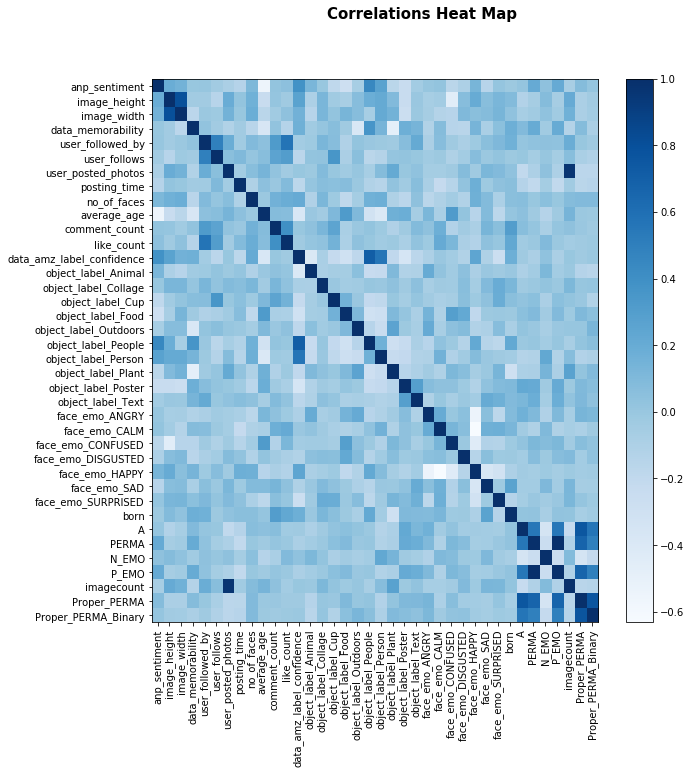

In [270]:
# Plot Correlation Matrix using Matplotlib
%pylab inline
plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Correlations Heat Map', fontsize=15, fontweight='bold')
plt.show()

### Prepare train and test set

In [271]:
new_df = regr_df

new_df.dropna(how='any', inplace=True)

In [272]:
X = new_df[['user_posted_photos', 'user_follows', 'user_followed_by', 'no_of_faces', 'imagecount']].copy()

y = new_df['PERMA'].copy()

In [273]:
X = new_df[['user_posted_photos', 'user_follows', 'user_followed_by', 'posting_time',\
            'no_of_faces', 'object_label_Animal', 'object_label_Collage', 'object_label_Cup',\
            'object_label_Food', 'object_label_Outdoors', 'object_label_People',\
            'object_label_Person','object_label_Plant', 'object_label_Poster', 'object_label_Text']].copy()
y = new_df['PERMA'].copy()

In [274]:
X = new_df[['face_emo_ANGRY','object_label_Food','object_label_Cup','anp_sentiment',\
            'object_label_Person','user_posted_photos','imagecount','face_emo_CALM','object_label_Animal']].copy()
y = new_df['Proper_PERMA'].copy()

In [307]:
X = new_df[['no_of_faces','object_label_Person','object_label_Outdoors','user_posted_photos']].copy()
y = new_df['Proper_PERMA_Binary'].copy()

In [308]:
X.head()

,no_of_faces,object_label_Person,object_label_Outdoors,user_posted_photos
1097967773,1.232558,0.420849,0.000000,282.0
11520833,1.701754,0.211155,0.007968,312.0
1223036636,1.461538,0.128205,0.000000,48.0
1224423305,1.000000,0.052632,0.000000,41.0
1249457735,1.500000,0.538462,0.038462,30.0


In [309]:
y.head()

1097967773    0
11520833      1
1223036636    1
1224423305    1
1249457735    1
Name: Proper_PERMA_Binary, dtype: int64

### Logistic Regression

In [310]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lm = LogisticRegression()

y_predict = cross_val_predict(LogisticRegression(), X, y, cv=15)

accuracy = metrics.accuracy_score(y, y_predict)

print('Accuracy: ', accuracy)

# Show metrics
#print('Coefficients: \n', lm.coef_)
# The mean squared error
# print("Mean squared error: %.2f"
#       % mean_squared_error(y, y_predict))
# # Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_predict))

Accuracy:  0.825174825175
Variance score: -0.30


### Logistic Regression IT

In [315]:
import mord as m

lm = m.LogisticIT()

y_predict = cross_val_predict(lm, X, y, cv=15)

accuracy = metrics.accuracy_score(y, y_predict)

print('Accuracy: ', accuracy)

# Show metrics
#print('Coefficients: \n', lm.coef_)
# The mean squared error
# print("Mean squared error: %.2f"
#       % mean_squared_error(y, y_predict))
# # Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_predict))

Accuracy:  0.825174825175
Variance score: -0.30


In [312]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(X)

lm = LogisticRegression()

preds = []

X = np.array(X)
y = np.array(y)

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lm.fit(X_train, y_train)
    
    prediction = lm.predict(X_test)
    
    preds.append(prediction)
    
accuracy = metrics.accuracy_score(y, preds)

print('Accuracy: ', accuracy)

Accuracy:  0.825174825175


### Linear Regression

In [313]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

y_predict = cross_val_predict(regr, X, y, cv=15)
y_predict_round = list(map(round, y_predict))

# Round all predictions so we can measure the accuracy (its not classification)
accuracy = metrics.accuracy_score(y, y_predict_round)

print('Accuracy: ', accuracy)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_predict))

Accuracy:  0.825174825175
Variance score: 0.01


## Results from regression

#### 1. PERMA ~ anp_sentiment

Correlation: 0.21477

Coefficients: 
 [[ 4.68761213]]
Mean squared error: 3.59
Variance score: 0.03

#### 2. PERMA ~ posting_time

correlation: -0.205047

Coefficients: 
 [[-0.12492383]]
Mean squared error: 2.93
Variance score: -0.08

#### 3. PERMA ~ data_memorability

correlation: 0.195383

Coefficients: 
 [[ 9.01465037]]
Mean squared error: 1.98
Variance score: -0.04

#### 4. PERMA ~ imagecount	

correlation: -0.112792

Coefficients: 
 [[-0.00031376]]
Mean squared error: 3.32
Variance score: 0.04
